# Import libraries

In [1]:
import sys
sys.path.insert(0,'..')

In [2]:
import os
import sys
from pathlib import Path

import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.dates as mdates
from matplotlib import colors
import h5py
import re
from typing import Optional
import datetime as dt

from functools import partial
from multiprocessing import Pool

#from lhcsmapi.Time import Time
#from lhcsmapi.Timer import Timer
#from lhcsmapi.metadata.MappingMetadata import MappingMetadata
from scipy import signal
import xarray as xr
import numpy as np
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy.signal import find_peaks

from src.dataset import load_dataset
from src.datasets.rb_fpa_prim_quench_ee_plateau2_V2 import RBFPAPrimQuenchEEPlateau2_V2
from src.datasets.rb_fpa_prim_quench_ee_plateau_V2 import RBFPAPrimQuenchEEPlateau_V2
from src.utils.frequency_utils import *
from src.visualisation.fft_visualisation import plot_nmf_components, plot_position_frequency_map, plot_NMF, plot_nmf_event_composition, plot_avg_component_weight, plot_distribution_over_column, plot_component_distribution, plot_cweight_distribution_all_data
from src.visualisation.visualisation import make_gif
from src.models.nmf import NMF
from src.utils.utils import pd_dict_filt, nanargsort, merge_array
from src.utils.sort_utils import map_position_index, center_array, split_main_mirror, calc_snr, main_mirror_to_el, generate_sorted_value_dict

pd.set_option('display.max_rows', 200)
import warnings
warnings.filterwarnings('ignore')


# Define Paths

In [3]:
file_path  = Path('/eos/project/m/ml-for-alarm-system/private/RB_signals')
data_path = file_path / 'backup/20220707_data'

# Read the (clean) MP3 file

In [4]:
# define paths to read
context_path = Path("../data/MP3_context_data/20230313_RB_processed.csv")
snapshot_context_path = Path("../data/RB_snapshot_context.csv")

# define paths to read + write
dataset_path = Path("/eos/project/m/ml-for-alarm-system/private/RB_signals/backup/20230313_RBFPAPrimQuenchEEPlateau_V2")
dataset_path2 = Path("/eos/project/m/ml-for-alarm-system/private/RB_signals/backup/20230313_RBFPAPrimQuenchEEPlateau2_V2")

# load desired fpa_identifiers
mp3_fpa_df = pd.read_csv(context_path)
snapshot_context_df = pd.read_csv(snapshot_context_path)
mp3_fpa_df = pd.concat([mp3_fpa_df[mp3_fpa_df['timestamp_fgc'] >= 1526582397220000000], snapshot_context_df])
drop_events = ["RB_RB.A78_1619330143440000000", "RB_RB.A45_1544355147780000000", "RB_RB.A45_1544300287820000000"] # known outliers to drop

acquisition_summary_path = Path("../data/20230313_acquisition_summary.csv")
acquisition_summary = pd.read_csv(acquisition_summary_path)
drop_events.append(acquisition_summary[acquisition_summary["U_diode_data_useable"] != 1].fpa_identifier.values)

mp3_fpa_df = mp3_fpa_df[~mp3_fpa_df.fpa_identifier.isin(drop_events)]
mp3_fpa_df_unique = mp3_fpa_df.drop_duplicates(subset=['fpa_identifier'])
len(mp3_fpa_df), len(mp3_fpa_df_unique)

(3455, 731)

# Load Data

In [5]:
# load data 1EE
dataset_creator = RBFPAPrimQuenchEEPlateau_V2()
ds1 = dataset_creator.load_dataset(fpa_identifiers=mp3_fpa_df_unique.fpa_identifier.values,
                                  dataset_path=dataset_path)
# load data 1EE
dataset_creator = RBFPAPrimQuenchEEPlateau2_V2()
ds2 = dataset_creator.load_dataset(fpa_identifiers=mp3_fpa_df_unique.fpa_identifier.values,
                                  dataset_path=dataset_path2)

In [6]:
# append 1st and second EE Plateau
ds_detrend1 = dataset_creator.detrend_dim(ds1, deg=-1)
ds_detrend1.coords["t0"] = ds_detrend1["time"].values[0]
ds_detrend1["time"] = ds_detrend1["time"].values - ds_detrend1["time"].values[0]
ds_detrend2 = dataset_creator.detrend_dim(ds2, deg=-1)
ds_detrend2 = ds_detrend2.isel(time=slice(0, 400))
ds_detrend2.coords["t0"] = ds_detrend2["time"].values[0]
ds_detrend2["time"] = ds_detrend1["time"]
ds_detrend2.coords["plateau_number"] = 2
ds_detrend = xr.concat([ds_detrend1, ds_detrend2], dim="event")
ds = xr.concat([ds1, ds2], dim="event")

In [7]:
# calculate fft
f_window = np.hanning
f_lim = (0, 534)
da_fft = get_fft_of_DataArray(data=ds_detrend.data, f_window=f_window, f_lim=f_lim)
da_fft_amplitude = scale_fft_amplitude(data=da_fft, f_window=f_window)
da_fft_amplitude = da_fft_amplitude[:, :, da_fft_amplitude.frequency < f_lim[1]]

In [8]:
lower_bound = 1e-4
upper_bound = 1e-1
na_scaled = np.array([dataset_creator.log_scale_data(x, vmin=lower_bound, vmax=upper_bound)
                        for x in da_fft_amplitude.data])

na_processed = np.nan_to_num(na_scaled.reshape(-1, np.shape(na_scaled)[2]))

## Define training data

In [9]:
# make bools of different plateaus and experiment types
test_conditions = ((mp3_fpa_df['Delta_t(iQPS-PIC)'] / 1000 < 5) &
                   (mp3_fpa_df['Nr in Q event'].astype(str) != '1'))
bool_test = np.isin(ds_detrend.event.values, mp3_fpa_df[test_conditions].fpa_identifier.unique())
snapshot_conditions = mp3_fpa_df["Date (FGC)"].isna()
bool_snapshot = np.isin(ds_detrend.event.values, mp3_fpa_df[snapshot_conditions].fpa_identifier.unique())
bool_1EE = (ds_detrend.t0.values < 0.5)
bool_2EE = (ds_detrend.t0.values > 0.5)

bool_train_flattened = np.stack([~(bool_test | bool_snapshot) for l in range(na_scaled.shape[1])]).T.reshape(-1)

print(f"1EE: {int(len(bool_test) / 2)} events = {int(sum(~(bool_test | bool_snapshot)) / 2)} normal + {int(sum(bool_test)/ 2)} fast sec + {int(sum(bool_snapshot)/ 2)} snapshots")


1EE: 699 events = 494 normal + 157 fast sec + 48 snapshots


# <h1><center><font size="30">Non-negative components - NMF</font></center></h1>

<h1><font size="8">1st Energy Extraction Plateau</font></h1>

<AxesSubplot:xlabel='frequency'>

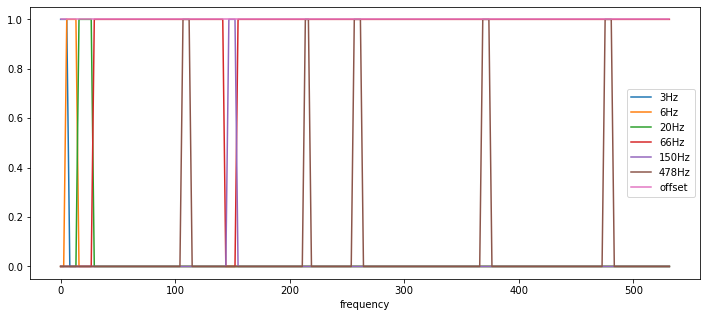

In [10]:
df_components = pd.read_csv("../data/final_components/components_merged_V2.csv", index_col=0)

#df_components = df_components.drop(columns="6Hz")
df_components = df_components / df_components.max(axis=0)
df_components.plot(figsize = (12,5))

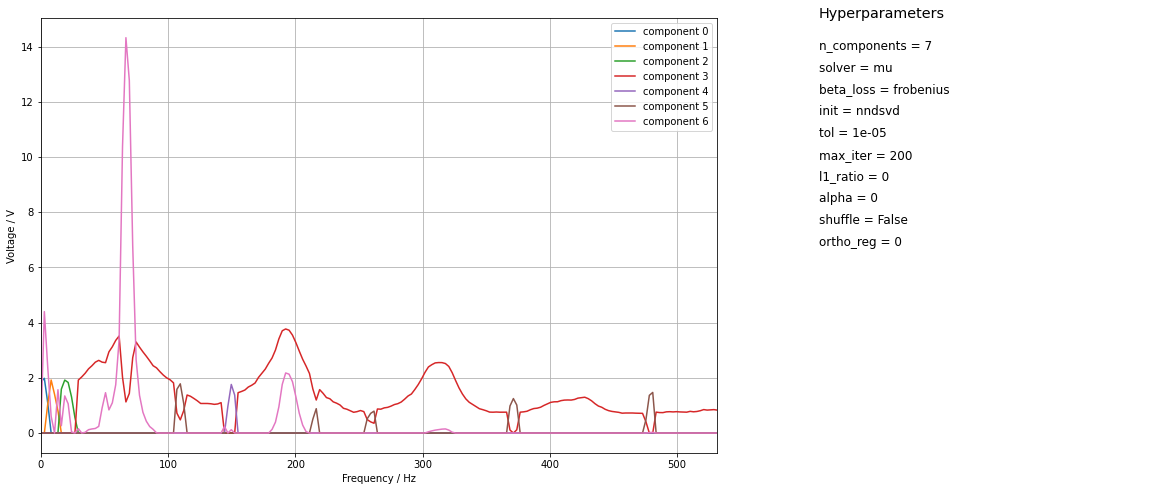

In [11]:
hyperparameter = {
    "n_components": 7,
    "solver": "mu",
    "beta_loss": 'frobenius',
    "init": "nndsvd",
    "tol": 1e-5,
    "max_iter": 200,
    "l1_ratio": 0,
    "alpha": 0,
    "shuffle": "False",
    "ortho_reg": 0 
}
nmf_model = NMF(**hyperparameter)
nmf_model.fit(X=na_processed[bool_train_flattened], H=df_components.values.T, not_init_H_idx=True)
W = nmf_model.transform(X=na_processed)
H = nmf_model.components_

plot_nmf_components(H, da_fft_amplitude, hyperparameters=hyperparameter, norm_component=False)

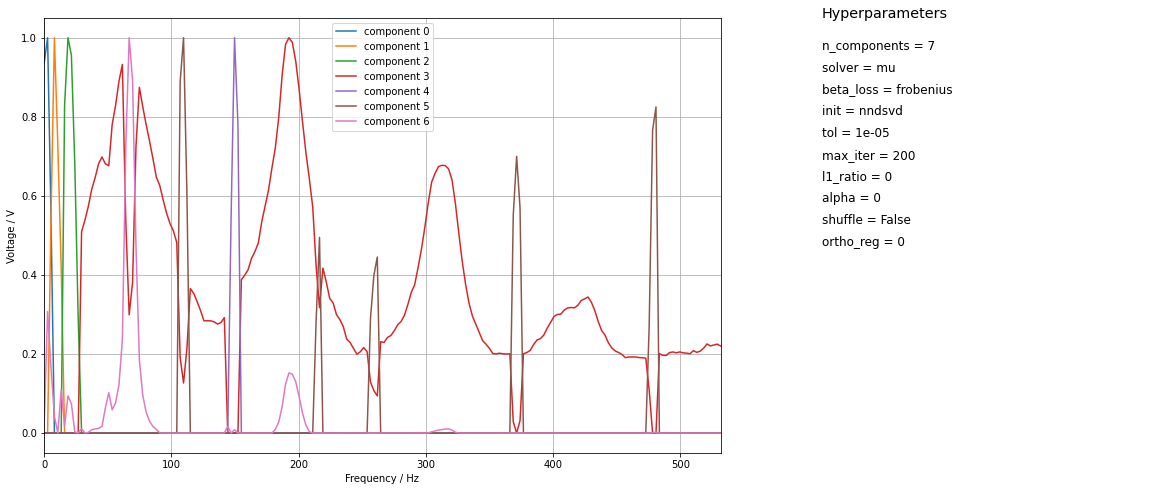

In [12]:
# norm components
H_processed, W_processed = nmf_model.normalize_H(H=H, W=W)
plot_nmf_components(H_processed, da_fft_amplitude, hyperparameters=hyperparameter, norm_component=False)

# Check components

In [13]:
fpa_identifiers = da_fft_amplitude.event.values
use_fpa_identifier = True
if use_fpa_identifier:
    # provide fpa_identifier
    fpa_identifier = 'RB_RB.A78_1617170255140000000'
    event_idex = np.argmax(fpa_identifiers == fpa_identifier)
else: 
    # provide event_index 
    event_idex = 1 #30
    ds_fft_cut = ds_fft.loc[{'event': fpa_identifiers}]
    fpa_identifier =  ds_fft_cut[{'event': event_idex}].event.values

date = mp3_fpa_df[mp3_fpa_df.fpa_identifier == fpa_identifier]['Timestamp_PIC'].values[0]
event_idex, fpa_identifier, date

(49, 'RB_RB.A78_1617170255140000000', '2021-03-31 07:57:35.120000')

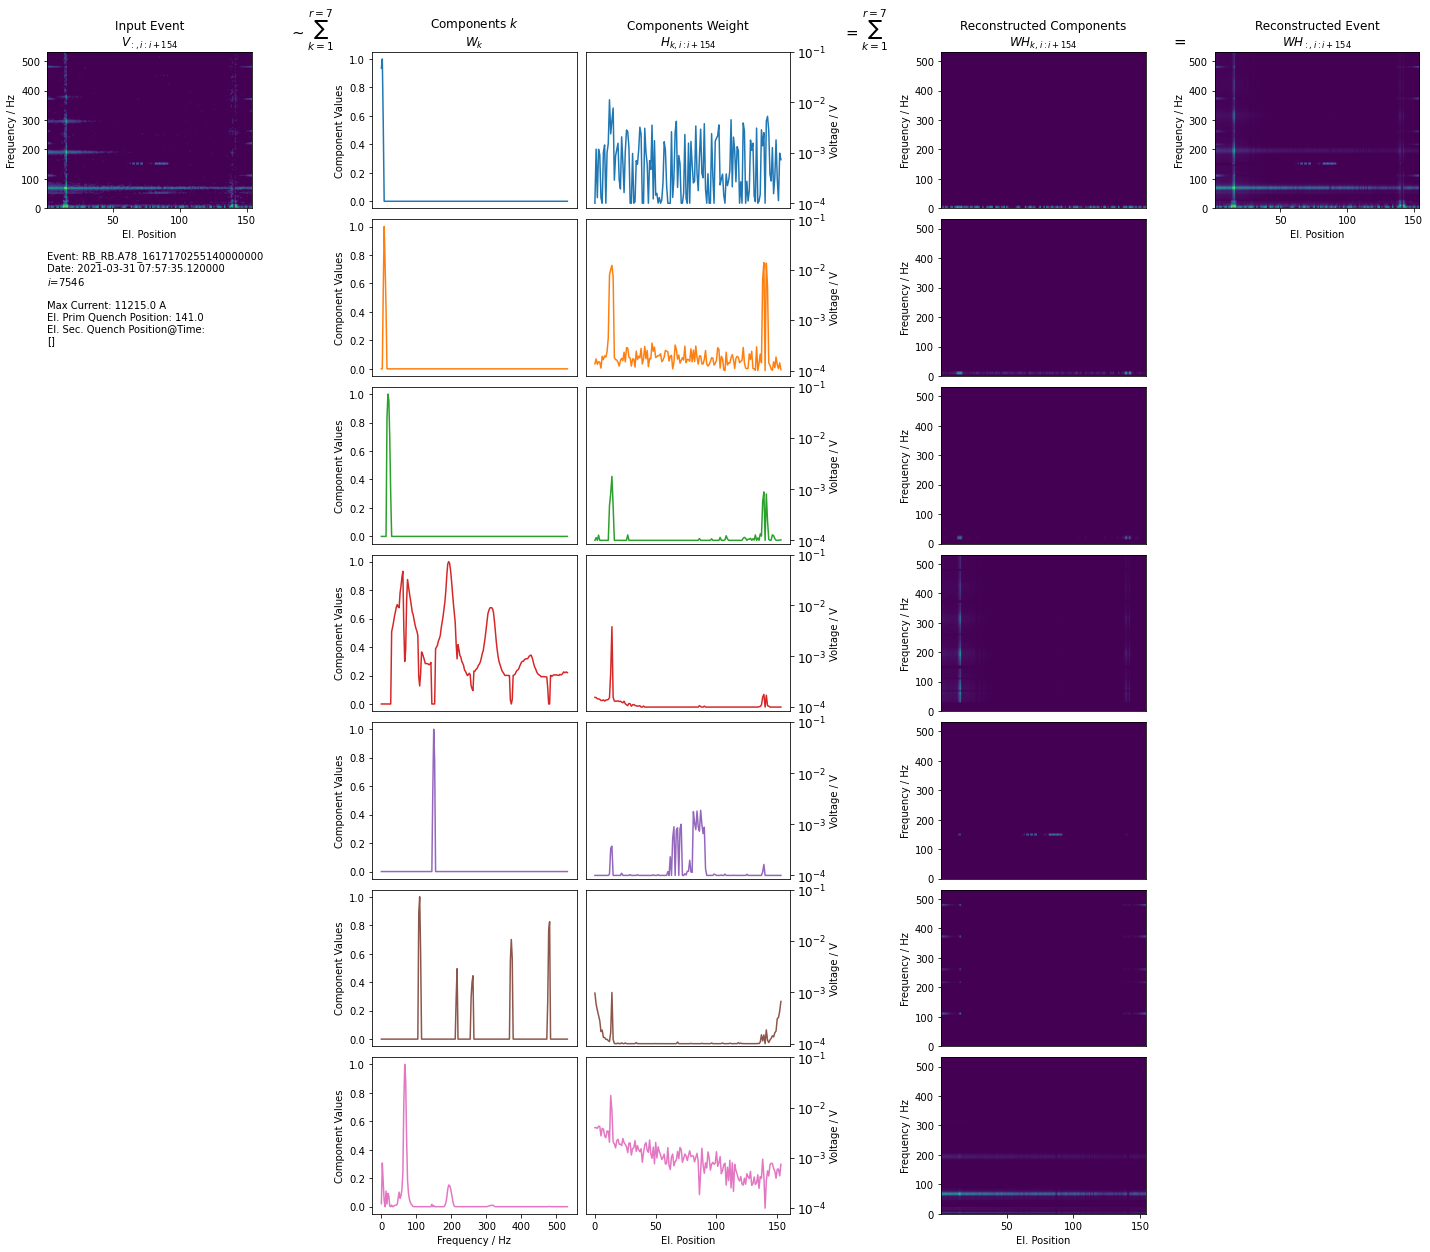

In [14]:
component_indexes = np.arange(len(H))
plot_nmf_event_composition(na_processed, W_processed, H_processed, component_indexes, da_fft_amplitude, fpa_identifier, mp3_fpa_df, vmin=lower_bound, vmax=upper_bound)

(0.0, 270.0)

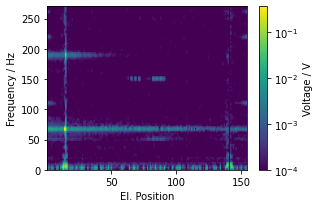

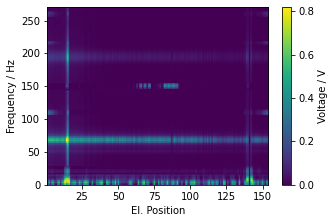

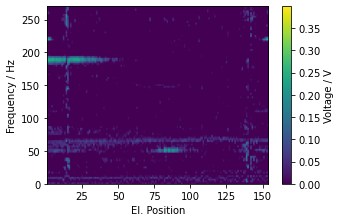

In [15]:
event_idex =49

fig, ax = plt.subplots(figsize = (4.5, 3))

im = plot_position_frequency_map(ax, na_processed[event_idex * 154:event_idex * 154 + 154], da_fft_amplitude.frequency, norm=None, vmin=None, vmax=None)
ax.set_ylabel('Frequency / Hz')
ax.set_xlabel('El. Position')
cbar = fig.colorbar(im, ax=ax)
cbar.set_label('Voltage / V')


vmax = 1
vmin = 1e-4
vdiff = np.log10(vmax) - np.log10(vmin)
n_ticks = int(vdiff) + 1
cbar.set_ticks(np.linspace(0, 1, n_ticks))
cbar.set_ticklabels([f"$10^{{{int(np.log10(vmin)) + a}}}$" for a in range(n_ticks)])
plt.tight_layout()
plt.ylim((0, 270))
plt.savefig('t.svg')

fig, ax = plt.subplots(figsize = (4.5, 3))
im = plot_position_frequency_map(ax, W[event_idex * 154:event_idex * 154 + 154] @ H, da_fft_amplitude.frequency, norm=None, vmin=None, vmax=None)
ax.set_ylabel('Frequency / Hz')
ax.set_xlabel('El. Position')
cbar = fig.colorbar(im, ax=ax)
cbar.set_label('Voltage / V')
plt.ylim((0, 270))
#cbar.set_ticks(np.linspace(0, 1, n_ticks))
#cbar.set_ticklabels([f"$10^{{{int(np.log10(vmin)) + a}}}$" for a in range(n_ticks)])

fig, ax = plt.subplots(figsize = (4.5, 3))
diff = na_processed[event_idex * 154:event_idex * 154 + 154] - W[event_idex * 154:event_idex * 154 + 154] @ H
diff[diff<0] = 0
im = plot_position_frequency_map(ax, diff, da_fft_amplitude.frequency, norm=None, vmin=None, vmax=None)
ax.set_ylabel('Frequency / Hz')
ax.set_xlabel('El. Position')
cbar = fig.colorbar(im, ax=ax)
cbar.set_label('Voltage / V')
plt.ylim((0, 270))

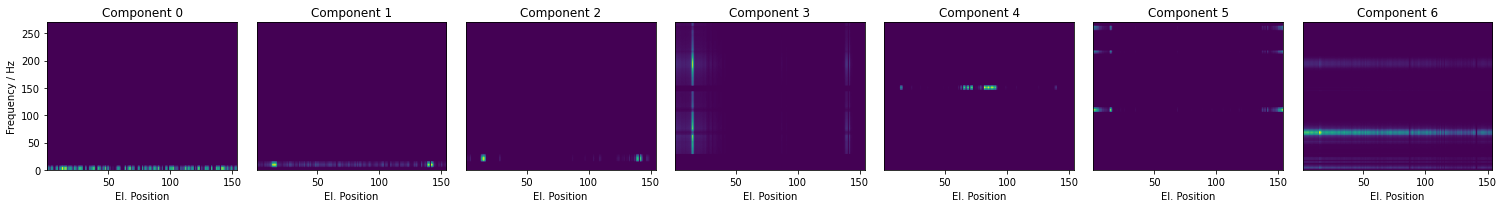

In [16]:
component_indexes_1EE = [0,1,2,3,4,5,6]
W = W_processed
H = H_processed

fig, ax = plt.subplots(1, len(H), figsize = (len(H)*3, 3))
for k, i in enumerate(component_indexes_1EE):
    
    if isinstance(i, list):
        W_temp = 0
        H_temp = 0
        for j in i:
            W_temp += W[event_idex * 154:event_idex * 154 + 154, j:j + 1]
            H_temp += H[j:j + 1]
        H_temp /= len(i)  # sum components, mean weight, or other way around
    else:
        W_temp = W[event_idex * 154:event_idex * 154 + 154, i:i + 1]
        H_temp = H[i:i + 1]
    na_reconstructed = W_temp @ H_temp
    im = plot_position_frequency_map(ax[k], na_reconstructed, da_fft_amplitude.frequency, norm=None, vmin=None, vmax=None)
    
    if i == 0:
        ax[k].set_ylabel('Frequency / Hz')
    else:
        ax[k].set_yticks([])
    ax[k].set_xlabel('El. Position')
    ax[k].set_title(f'Component {k}')
    ax[k].set_ylim((0, 270))
        
    
plt.tight_layout()

# Save components for correlations

In [17]:
W_unscaled = dataset_creator.exp_scale_data(W_processed, vmin = 1e-4, vmax = 1e-1)

#np.save("../data/final_components/cweights_fitted.npy", H_processed)
#np.save("../data/final_components/weights_fitted.npy", W_unscaled)
#np.save("../data/final_components/weights_fitted_log.npy", W_processed)

In [168]:
columns = ["3Hz", "6Hz", "20Hz", "offset", "150Hz", "478Hz", "66Hz"]
index = np.stack([da_fft_amplitude.event for l in range(na_scaled.shape[1])]).T.reshape(-1)
df_comp = pd.DataFrame(W_unscaled, columns = columns, index=index)

df_comp['El. Position'] = np.stack([da_fft_amplitude.el_position for l in range(na_scaled.shape[0])]).reshape(-1) +1
df_comp['1EE'] = np.stack([bool_1EE +0  for l in range(na_scaled.shape[1])]).T.reshape(-1)

In [158]:
# Measure components, not from NMF but from Data directly
dominant_frequencies = ["3Hz_meas", "6Hz_meas", "20Hz_meas", "66Hz_meas", "150Hz_meas", "478Hz_meas"]
idx_dominant_frequencies = [1, 3, 7, 25, 56, 180]

W_measured = da_fft_amplitude.values[:,:,idx_dominant_frequencies].reshape(-1,len(idx_dominant_frequencies))

df_comp_measured = pd.DataFrame(W_measured, columns=dominant_frequencies, index=index)
df_comp_measured["offset_measured"] = np.nanmedian(da_fft_amplitude.values.reshape(-1, 200),axis=1)

# add in logscale
for d in df_comp_measured.columns:
    df_comp_measured[f"{d}_log"] = np.log10(df_comp_measured[d].values)

In [159]:
# Exp. trend coeff. are calculated for t=0, need to be transformed
def get_fit(ds):
    fit_coeff = ds['polyfit_coefficients']
    p = fit_coeff.values.reshape(fit_coeff.shape[:-1] + (-1, 1))
    t = ds.time.values.reshape((1, 1, -1))
    fit = exponential_func(t, p[:, :, 0, :], p[:, :, 1, :], p[:, :, 2, :])
    return fit

df_trend = pd.DataFrame(ds_detrend.polyfit_coefficients.values.reshape(-1,3), index=index, columns=["A","tau","C"])
df_trend["B"] = df_trend["tau"] 
df_trend["tau"] = 1 / df_trend["B"] 

fit_1EE = get_fit(ds1).reshape(-1,ds1.time.shape[-1])
fit_2EE = get_fit(ds2).reshape(-1,ds2.time.shape[-1])
df_trend["A_init"] = np.hstack((fit_1EE[:,0], fit_2EE[:,0]))
df_trend["C_init"] = np.hstack((fit_1EE[:,-1], fit_2EE[:,-1]))
df_trend["dAC"] = df_trend["A_init"] - df_trend["C_init"]

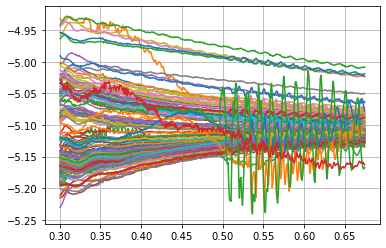

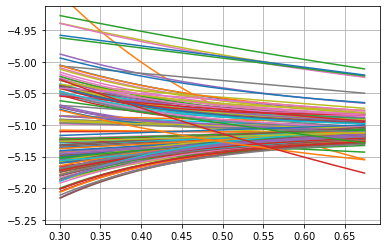

In [160]:
fig, ax = plt.subplots()
ax.plot(ds1.time,ds1.data[1].T)
ylim = ax.get_ylim()
plt.grid()
plt.show()

fig, ax = plt.subplots()
ax.plot(ds1.time,fit[1].T)
ax.set_ylim(ylim)
plt.grid()
plt.show()

In [169]:
df_corr = pd.concat([df_comp, df_comp_measured, df_trend], axis=1)
df_corr.to_csv("../data/final_components/cweights_trend.csv", index_label="fpa_identifier")

In [171]:
df_corr

,3Hz,6Hz,20Hz,offset,150Hz,478Hz,66Hz,El. Position,1EE,3Hz_meas,...,150Hz_meas_log,478Hz_meas_log,offset_measured_log,A,tau,C,B,A_init,C_init,dAC
RB_RB.A34_1528374951920000000,0.000100,0.000100,0.000100,0.000100,0.000100,0.000100,0.000100,1,1,NaN,...,NaN,NaN,NaN,-0.937078,9.067218e-41,0.937078,1.102874e+40,0.000000,0.000000,0.000000
RB_RB.A34_1528374951920000000,0.001170,0.006775,0.008027,0.000351,0.000231,0.000178,0.001799,2,1,0.011960,...,-3.742149,-4.218471,-4.053149,336.846053,6.796480e-04,-341.874036,1.471350e+03,-5.096821,-5.182296,0.085475
RB_RB.A34_1528374951920000000,0.003484,0.006135,0.008163,0.000349,0.000257,0.000158,0.001727,3,1,0.013723,...,-3.731511,-4.230349,-4.076484,338.637336,2.586363e-04,-343.782119,3.866433e+03,-5.171120,-5.203826,0.032707
RB_RB.A34_1528374951920000000,0.002243,0.006332,0.008001,0.000337,0.000183,0.000159,0.001544,4,1,0.012580,...,-3.839715,-4.566362,-4.112886,318.661805,4.965979e-04,-323.761936,2.013702e+03,-5.147715,-5.206802,0.059088
RB_RB.A34_1528374951920000000,0.002875,0.005967,0.007756,0.000303,0.000229,0.000143,0.001488,5,1,0.012684,...,-3.681475,-4.251143,-4.149628,0.524635,3.637141e+00,-5.233702,2.749412e-01,-5.057972,-5.188526,0.130555
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
RB_RB.A81_1648207115180000000,0.000210,0.000102,0.000116,0.000100,0.000100,0.000100,0.000107,150,0,0.000399,...,-4.736733,-4.489554,-4.378483,-0.181507,1.140376e+00,-4.472235,8.769039e-01,-4.545081,-4.507486,-0.037595
RB_RB.A81_1648207115180000000,0.000264,0.000101,0.000144,0.000100,0.000100,0.000100,0.000103,151,0,0.000418,...,-4.342324,-4.233761,-4.374290,-225.956184,2.086169e-04,221.392329,4.793475e+03,-4.526121,-4.496124,-0.029997
RB_RB.A81_1648207115180000000,0.000253,0.000105,0.000150,0.000100,0.000100,0.000100,0.000108,152,0,0.000538,...,-5.188698,-4.996272,-4.331376,-429.884118,1.123386e-04,425.306648,8.901663e+03,-4.538811,-4.508077,-0.030735
RB_RB.A81_1648207115180000000,0.000570,0.000100,0.000146,0.000100,0.000100,0.000101,0.000100,153,0,0.000714,...,-4.200839,-4.599668,-4.353299,-220.437795,1.568621e-04,215.880661,6.375027e+03,-4.529453,-4.507448,-0.022005
